In [1]:
from imports import *
from exactDiagMethods import *
from globalMethods import  *
from vqteMethods import *


## H imag * iH real
## Compare matricies in seperate file
## Look at Joaquins python file for this 

In [2]:
def main():
    # Initialize the simulation parameters
    N = 1
    gamma_L= 0.2
    gamma_R = 1.0
    eps = 1
    mu_L= 0.25
    mu_R= 1
    T_L = 10   
    T_R= 1
    beta_L=1/T_L
    beta_R=1/T_R
    F_L = 1/(np.exp(beta_L*(eps-mu_L))+1)
    F_R = 1/(np.exp(beta_R*(eps-mu_R))+1)
    J = 1
    
    #Layer = 2

    eps_list = []

    for i in range(N):
        eps_list.append(1)

  
    time = 6.0
    dt = 0.3
    nt = int(time/dt)

    

    exact_diag_ham = build_exact_diag_hamiltonian(J, eps_list)

    #print("Exact Ham", exact_diag_ham)

    ham_real, ham_imag = hamiltonian_generation(N, eps_list, gamma_L, gamma_R, F_L, F_R, J)

    
    
    # Generate initial states
    vqte_init_state, exact_diag_init_state, ansatz, init_param_values = build_initial_states(ham_real)


    exact_diag_results, superoperator = perform_exact_diag(gamma_L,F_L, gamma_R, F_R, dt, nt, exact_diag_init_state,exact_diag_ham, N)
    
    print("This is the superoperator", superoperator)
    print("Ham real ", ham_real)
 

    #print("This is important", superoperator - (ham_imag.to_matrix()+ 1j*ham_real.to_matrix()))
    
 

    
    #print("Superoperator from exact diag method: ", superoperator)
    vqte_results, numoplist = perform_vqte(ham_real, ham_imag, vqte_init_state, dt, nt, ansatz, init_param_values)
    
    #print("Difference", compare_superoperator_to_vqte(superoperator, ham_real, ham_imag) )
    
    #print("Number Operators: ", numoplist)
    # # Output results
    
    output_results(vqte_results, exact_diag_results, time, nt)

This is the superoperator [[-0.59625176+0.j  0.        +0.j  0.        +0.j  0.60374824+0.j]
 [ 0.        +0.j -0.6       -1.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j -0.6       +1.j  0.        +0.j]
 [ 0.59625176+0.j  0.        +0.j  0.        +0.j -0.60374824+0.j]]
Ham real  SparsePauliOp(['ZI', 'IZ', 'XY', 'YX'],
              coeffs=[ 0.5       +0.j, -0.5       +0.j, -0.00187412+0.j, -0.00187412+0.j])
Step 0 out of 20
Step 1 out of 20
Step 2 out of 20
Step 3 out of 20
Step 4 out of 20
Step 5 out of 20
Step 6 out of 20
Step 7 out of 20
Step 8 out of 20
Step 9 out of 20
Step 10 out of 20
Step 11 out of 20
Step 12 out of 20
Step 13 out of 20
Step 14 out of 20
Step 15 out of 20
Step 16 out of 20
Step 17 out of 20
Step 18 out of 20
Step 19 out of 20


c:\Users\tessa\Documents\GitHub\open-quantum-systems-simulation\.venv\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\tessa\Documents\GitHub\open-quantum-systems-simulation\.venv\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


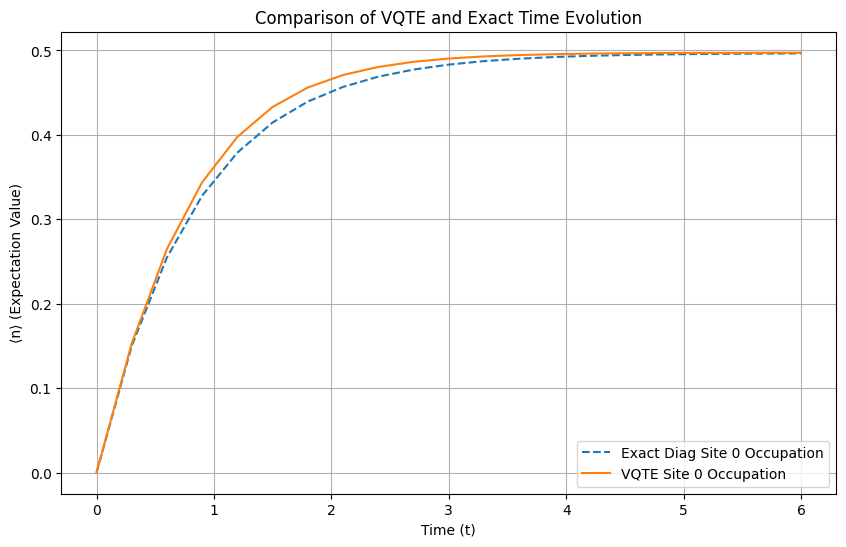

In [3]:
main()